# Applying the Model

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
#img_md_subset = pd.read_csv('../../../Data/all_images_231020.csv')

Now we're running the model on new data that hasn't had all the easy classes pulled from it

In [ ]:
import glob, os

tsv_list = []
for file in glob.glob("../../../Data/fresh_data_012121/live/all_imagery/*.tsv", recursive=True):
    tsv_list.append(file)
    
print(len(tsv_list))

In [ ]:
img_md_subset = pd.read_csv(tsv_list[0], sep='\t').iloc[1:][['object_id', 'sample_flag', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_peak_fluorescence', 'object_peak_scattering', 'object_equiv_diameter']]

for tsv in tsv_list[1:]:
    df_to_add = pd.read_csv(tsv, sep='\t').iloc[1:][['object_id', 'sample_flag', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_peak_fluorescence', 'object_peak_scattering', 'object_equiv_diameter']]
    img_md_subset = img_md_subset.append(df_to_add, ignore_index=True)

In [ ]:
len(img_md_subset)

In [ ]:
img_md_subset.columns

In [ ]:
#img_md_subset.to_csv('../../../Data/fresh_data_012121/preserved/ifcb_ecotaxa_subset_012421.csv')
#img_md_subset.to_csv('../../../Data/fresh_data_012121/live/ifcb_ecotaxa_subset_012421.csv')
img_md_subset = pd.read_csv('../../../Data/fresh_data_012121/preserved/ifcb_ecotaxa_subset_012421.csv')

In [2]:
# reading in the small subsets that schuyler predicted on

img_md_subset = pd.read_csv('../../../Data/fresh_data_012121/live/ecotaxa_cnn_predictions_live_100_per_class_240121.csv', sep='\t')
#img_md_subset = pd.read_csv('../../../Data/fresh_data_012121/preserved/ecotaxa_cnn_predictions_preserved_with_live_model_100_per_class_250121.csv', sep='\t')

In [2]:
# new random subset of 10,000 samples
img_md_subset = pd.read_csv('../../../Data/fresh_data_012121/ecotaxa_export_live_10000_100221.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (264) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
img_md_subset.head()

,object_id,object_lat,object_lon,object_date,object_time,object_link,object_depth_min,object_depth_max,object_annotation_status,object_annotation_person_name,...,process_soft,process_soft_version,process_script,process_script_version,process_library,process_library_version,process_date,process_time,acq_id,acq_instrument
0,D20171212T201207_IFCB116_00106,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
1,D20171212T201207_IFCB116_00378,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
2,D20171212T201207_IFCB116_00602,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
3,D20171212T201207_IFCB116_01090,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
4,D20171212T201207_IFCB116_01165,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN


In [4]:
# drop unwanted classes

# Here are groups we can cut:
classes_to_drop = ['Banquisia belgicae',
'Dinophyceae',
'pennate<Bacillariophyta',
'Licmophora',
'Rhizosolenia',
'centric 4 temp',
'centric 6 temp',
't005',
't006',
't009',
't019',
't020',
'Warnowia',
'Unknowns'
]

img_md_subset = img_md_subset.drop(img_md_subset[img_md_subset.object_annotation_category.isin(classes_to_drop)].index)
len(img_md_subset)

9517

In [5]:
# Here are groups we can combine:

img_md_subset[img_md_subset.object_annotation_category == 'Tintinnida'] = 'Ciliophora'
img_md_subset[img_md_subset.object_annotation_category == 'Odontella sp.'] = 'chain<centric'
img_md_subset[img_md_subset.object_annotation_category == 'Eucampia chain'] = 'chain<centric'
len(img_md_subset)

9517

In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
import glob, os

file_dir = '../../../Data/fresh_data_012121/live/all_imagery/'

os.chdir(file_dir)

In [8]:
fn_list = []

for file in glob.glob("*.png"):
    fn_list.append(file)
    
print(len(fn_list))

fn_edit = [x[:-4] for x in fn_list]

available_subset = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(available_subset)

3038045


9517

In [9]:
import sys
 
sys.getsizeof(fn_edit) / 1e9

0.025105992

In [10]:
del fn_edit

In [11]:
del img_md_subset

In [12]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'badfocus<artefact': 20,
 'bead': 21,
 'bubble': 22,
 'centric': 23,
 'centric 1 temp': 24,
 'centric 2 temp': 25,
 'centric 3 temp': 26,
 'chain<centric': 27,
 'chain<pennate': 28,
 'detritus': 29,
 'dinoflagellate-i': 30,
 'dinoflagellate-ii': 31,
 'dinoflagellate-iii': 32,
 'multiple<other': 33,
 'pennate 1 temp': 34,
 'pennate 10 temp': 35,
 'pennate 11 temp': 36,
 'pennate 2 temp': 37,
 'pennate 7 temp': 38,
 't002': 39,
 't007': 40,
 't012': 41,
 't013': 42,
 'temp cylindrotheca': 43}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())
list(id_class_dict)

[id_class_dict[i] for i in range(len(id_class_dict))]

['Amphiprora',
 'Chaetoceros single',
 'Chaetoceros<Mediophyceae',
 'Ciliophora',
 'Corethron',
 'Cryptophyta',
 'Cylindrotheca',
 'Dactyliosolen',
 'Dictyochales',
 'Eucampia',
 'Gymnodinium',
 'Gyrodinium',
 'Katodinium',
 'Membraneis',
 'Navicula',
 'Nitzschia frigida',
 'Phaeocystis',
 'Proboscia sp.',
 'Pseudo-Nitzschia chain',
 'Pyramimonas',
 'badfocus<artefact',
 'bead',
 'bubble',
 'centric',
 'centric 1 temp',
 'centric 2 temp',
 'centric 3 temp',
 'chain<centric',
 'chain<pennate',
 'detritus',
 'dinoflagellate-i',
 'dinoflagellate-ii',
 'dinoflagellate-iii',
 'multiple<other',
 'pennate 1 temp',
 'pennate 10 temp',
 'pennate 11 temp',
 'pennate 2 temp',
 'pennate 7 temp',
 't002',
 't007',
 't012',
 't013',
 'temp cylindrotheca']

In [13]:
len(class_id_dict)

44

In [14]:
available_subset.memory_usage(index=True).sum() / 1e9

0.021394216

In [15]:
len(available_subset)

9517

In [16]:
#prediction_subset = available_subset.sample(frac=frac)
#prediction_subset = available_subset[:1630000] # presered is 1630000
prediction_subset = available_subset

In [17]:
del available_subset

In [18]:
prediction_subset.head()

,object_id,object_lat,object_lon,object_date,object_time,object_link,object_depth_min,object_depth_max,object_annotation_status,object_annotation_person_name,...,process_soft,process_soft_version,process_script,process_script_version,process_library,process_library_version,process_date,process_time,acq_id,acq_instrument
0,D20171212T201207_IFCB116_00106,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
1,D20171212T201207_IFCB116_00378,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
2,D20171212T201207_IFCB116_00602,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
3,D20171212T201207_IFCB116_01090,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
4,D20171212T201207_IFCB116_01165,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN


In [19]:
len(prediction_subset)

9517

In [ ]:
! ls ../../../../Code/deep_ifcb/metrics_700samples_noflu_50epochs/model_weights_all_classes_flu_iteration_noflu_50.hdf5

In [24]:
! pwd

/host/Data/fresh_data_012121/live/all_imagery


In [20]:
from tensorflow import keras

#model = keras.models.load_model('../../../../Code/deep_ifcb/metrics_700samples_noflu_50epochs/model_weights_all_classes_flu_iteration_noflu_50.hdf5')
#model = keras.models.load_model('../../../../Code/deep_ifcb/metrics_700samples_flu2_flu_scatter_50epochs_1000samples/model_weights_all_classes_flu_iteration_2flu_flu_scatter_50_1000.hdf5')
model = keras.models.load_model('../../../../Code/deep_ifcb/model_weights_all_classes_100221_2.hdf5')

In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

def generate_data(available_subset, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    while True:
        images = []
        labels = []
        merged_labels = []
        original_labels = []
        flu_data = []
        
        for b in range(batch_size):
            if i >= len(available_subset):
                i=0
            row = available_subset.iloc[i]
            i+=1
            
            #img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
            #images.append(image.img_to_array(img))
            desired_size = 150
            im = cv2.imread(row['object_id']+'.png', cv2.IMREAD_GRAYSCALE)
            old_size = im.shape[:2] # old_size is in (height, width) format
            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            # new_size should be in (width, height) format
            im = cv2.resize(im, (new_size[1], new_size[0]))
            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            new_im = cv2.copyMakeBorder(im, 0, delta_h, 0, delta_w, cv2.BORDER_CONSTANT,0)
            img = new_im[..., np.newaxis]

            images.append(img)
            #labels.append(class_id_dict[row['merged_category']])
            #merged_labels.append(row['merged_category'])
            #original_labels.append(row['object_annotation_category'])
            #flu_data.append([row['object_peak_fluorescence'], row['object_peak_scattering']])
        
        image_batch = np.array(images) / 130
        #flu_batch = np.array(flu_data)
        
        
        #yield [image_batch, flu_batch]
        yield [image_batch]

In [24]:
1630000 / 500, 3038000/500

(3260.0, 6076.0)

In [25]:
predict_prob = model.predict_generator(generator = generate_data(prediction_subset,batch_size=1), steps=9517/1, verbose=1)
#predict_prob = model.predict([X_predict, flu_data])

9517/9517 [==============================] - 33s 4ms/step


In [26]:
predict_prob.shape

(9517, 44)

In [27]:
predictions = np.argmax(predict_prob, axis=1)

In [28]:
predict_prob_values = []
for i in range(len(predictions)):
    predict_prob_values.append(predict_prob[i][predictions[i]])

In [29]:
np.mean(predict_prob_values), np.std(predict_prob_values)

(0.80076796, 0.23784816)

In [30]:
prediction_subset['image_file_name'] = prediction_subset['object_id'] + '.png'

In [31]:
len(predictions), len(prediction_subset)

(9517, 9517)

In [32]:
prediction_subset['object_annotation_category'] = [id_class_dict[x] for x in predictions]

In [33]:
prediction_subset['object_score'] = predict_prob_values

In [34]:
prediction_subset['object_annotation_status'] = 'Predicted'

In [35]:
prediction_subset = prediction_subset[['object_id','object_annotation_status','object_annotation_category','sample_flag','object_lat','object_lon','image_file_name','object_score']]

In [36]:
len(prediction_subset)

9517

In [37]:
prediction_subset.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
0,D20171212T201207_IFCB116_00106,Predicted,dinoflagellate-i,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00106.png,0.605285
1,D20171212T201207_IFCB116_00378,Predicted,Dactyliosolen,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00378.png,0.775176
2,D20171212T201207_IFCB116_00602,Predicted,Pyramimonas,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00602.png,0.999260
3,D20171212T201207_IFCB116_01090,Predicted,pennate 1 temp,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01090.png,0.631729
4,D20171212T201207_IFCB116_01165,Predicted,t002,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01165.png,0.942381


In [38]:
classes, counts = np.unique(predictions, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43]),
 array([   3,   29,   49,    5,   59,  392,  130,   81,    2,   19,    3,
           8,    9,  317,    9,    6,    5,  909, 2185,  115,   60,    2,
          67,   11,    7,    1,  192,   73,  271,  236,  659,    4,   19,
         598,    2, 2464,   17,  259,   35,  205]))

In [39]:
# go through the final predictions and find images where there are less than 150 validated and only include those in the final

# then only get ~300 of those maximum

In [40]:
prediction_subset.to_csv('live_predictions_10000_100221_2.csv', sep='\t')

In [ ]:
#prediction_subset= pd.read_csv('../../live/all_imagery/live_predictions_all_240121.csv', sep='\t')

grab a random sample of these predictions

In [ ]:
10000 / len(prediction_subset)

In [ ]:
len(prediction_subset.sample(frac=.0032916))

In [ ]:
sample_prediction_subset = prediction_subset.sample(frac=.0032916)

In [ ]:
sample_prediction_subset.to_csv('../../live/ecotaxa_cnn_predictions_live_with_live_model_random_sample_070221.csv', sep='\t')

In [ ]:
! pwd

### The below couple blocks allow filtering to only the rare classes for model iteration

In [ ]:
val_samples = pd.read_csv('../val_samples_021120.csv')
val_samples = val_samples.drop('Unnamed: 0', 1)
val_samples.head()

In [ ]:
# For now only using validated images
#img_md_subset = img_md_subset[img_md_subset.object_annotation_status == 'validated']

rare_count = 250

unique_validated = val_samples[val_samples.object_annotation_status == 'validated'].groupby('object_annotation_category')['object_id'].nunique()

rare_classes = unique_validated[unique_validated <= rare_count]

#val_img_subset = val_img_subset[val_img_subset['object_annotation_category'].isin(list(rare_classes.index))]
rare_classes

In [ ]:
rare_prediction_subset = prediction_subset[prediction_subset['object_annotation_category'].isin(list(rare_classes.index))]

In [ ]:
rare_prediction_subset.head()

In [ ]:
prediction_counts = rare_prediction_subset.groupby('object_annotation_category')['object_id'].nunique()
prediction_counts

In [ ]:
# filter out any that are in validation for the other file

rare_prediction_subset = rare_prediction_subset[~rare_prediction_subset.object_id.isin(list(img_md_subset.object_id))]

In [ ]:
prediction_counts = rare_prediction_subset.groupby('object_annotation_category')['object_id'].nunique()
prediction_counts

In [ ]:
len(rare_prediction_subset)

In [ ]:
# no longer doing this because we're actually assessing the accuracy
#rare_prediction_subset = rare_prediction_subset.sort_values('object_score', ascending=False)

In [ ]:
buckets = {}
for key in id_class_dict:
    buckets[key] = 0

object_ids = []

max_count = 300

for index, row in rare_prediction_subset.iterrows():
    if buckets[class_id_dict[row['object_annotation_category']]] < max_count:
        object_ids.append(row['object_id'])
        buckets[class_id_dict[row['object_annotation_category']]] += 1
len(object_ids)

rare_cut_df = rare_prediction_subset[rare_prediction_subset['object_id'].isin(object_ids)]
rare_cut_df.head()

In [ ]:
dtps = []
for dt in rare_cut_df.dtypes:
    if dt == 'float64':
        dtps.append('f')
    elif dt == 'object':
        dtps.append('t')
for f in dtps:
    print('['+f+']')

In [ ]:
rare_cut_df.to_csv('../ecotaxa_cnn_predictions_5150000_rare_131020.csv', sep='\t')

### Now to just output N of each class

In [ ]:
buckets = {}
for key in id_class_dict:
    buckets[key] = 0

object_ids = []

n = 100

for index, row in prediction_subset.iterrows():
    if buckets[class_id_dict[row['object_annotation_category']]] < n:
        object_ids.append(row['object_id'])
        buckets[class_id_dict[row['object_annotation_category']]] += 1
len(object_ids)

preds_n_per_class_df = prediction_subset[prediction_subset['object_id'].isin(object_ids)]
preds_n_per_class_df.head()

In [ ]:
len(preds_n_per_class_df)

In [ ]:
counts_per_class = preds_n_per_class_df.groupby('object_annotation_category')['object_id'].nunique()
counts_per_class.plot()

In [ ]:
preds_n_per_class_df.to_csv('../ecotaxa_cnn_predictions_preserved_with_live_model_100_per_class_250121.csv', sep='\t')

In [ ]:
[t]
[t]
[t]
[t]
[f]
[f]
[t]
[f]

In [ ]:
dtps = []
for dt in preds_n_per_class_df.dtypes:
    if dt == 'float64':
        dtps.append('f')
    elif dt == 'object':
        dtps.append('t')
for f in dtps:
    print('['+f+']')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(counts, classes)
ax.set_yticks(classes)
ax.set_yticklabels([id_class_dict[x] for x in classes])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('../output_predictions_131020.png', dpi=300)
plt.show()

In [ ]:
min_count = 20
unique_validated = available_subset.groupby('object_annotation_category')['object_id'].nunique()

sufficient_classes = unique_validated[unique_validated >= min_count]

In [ ]:
len(sufficient_classes)

In [ ]:
#classes, counts = np.unique(labels, return_counts=True)
classes, counts

In [ ]:
sufficient_classes

In [ ]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax.set_yticks(range(0,len(sufficient_classes)))
ax.set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(18, 18))
ax[1].scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax[1].set_yticks(range(0,len(sufficient_classes)))
ax[1].set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[1].set_axisbelow(True)
ax[1].set_xlim(-10,5000)
ax[1].set_title("Predictions")


# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[1].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax[0].scatter(counts, classes)
ax[0].set_yticks(range(0,len(class_id_dict)))
ax[0].set_yticklabels([id_class_dict[x] for x in classes])
ax[0].set_xlim(-10,2500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[0].set_axisbelow(True)
ax[0].set_title("Validated Data")

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[0].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('output_predictions_comparison_full.png', dpi=300)
plt.show()

### pull out only validated images and run it on them and see how close the total numbers compare

In [79]:
! pwd

/host/Data/fresh_data_012121/live/all_imagery


In [ ]:
! ls ../../live

In [43]:
len(prediction_subset)

9517

In [41]:
#live_preds = pd.read_csv('../ecotaxa_cnn_predictions_preserved_with_live_model_100_per_class_250121.csv', sep='\t')
#live_preds = pd.read_csv('../../live/ecotaxa_cnn_predictions_live_100_per_class_240121.csv', sep='\t')
live_preds = prediction_subset
live_preds['validated_type'] = ''
live_preds.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score,validated_type
0,D20171212T201207_IFCB116_00106,Predicted,dinoflagellate-i,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00106.png,0.605285,
1,D20171212T201207_IFCB116_00378,Predicted,Dactyliosolen,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00378.png,0.775176,
2,D20171212T201207_IFCB116_00602,Predicted,Pyramimonas,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00602.png,0.999260,
3,D20171212T201207_IFCB116_01090,Predicted,pennate 1 temp,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01090.png,0.631729,
4,D20171212T201207_IFCB116_01165,Predicted,t002,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01165.png,0.942381,


In [42]:
live_val = pd.read_csv('../../ecotaxa_export_live_10000_100221.csv')
live_val.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (264) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,object_id,object_lat,object_lon,object_date,object_time,object_link,object_depth_min,object_depth_max,object_annotation_status,object_annotation_person_name,...,process_soft,process_soft_version,process_script,process_script_version,process_library,process_library_version,process_date,process_time,acq_id,acq_instrument
0,D20171212T201207_IFCB116_00106,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
1,D20171212T201207_IFCB116_00378,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
2,D20171212T201207_IFCB116_00602,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
3,D20171212T201207_IFCB116_01090,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
4,D20171212T201207_IFCB116_01165,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN


In [43]:
live_val = live_val[['object_id','object_annotation_category']]

live_val = live_val.rename(columns={'object_annotation_category': 'validated_type'})
live_val.head()

,object_id,validated_type
0,D20171212T201207_IFCB116_00106,Cryptophyta
1,D20171212T201207_IFCB116_00378,multiple<other
2,D20171212T201207_IFCB116_00602,t002
3,D20171212T201207_IFCB116_01090,Pyramimonas
4,D20171212T201207_IFCB116_01165,t002


In [44]:
live_val = live_val.reset_index()

In [45]:
live_val[live_val['object_id'] == 'D20171212T201207_IFCB116_00106']

,index,object_id,validated_type
0,0,D20171212T201207_IFCB116_00106,Cryptophyta


In [46]:
# update the prediction dataframe with validated labels
print(len(live_preds))
live_preds = live_preds.set_index('object_id')
live_val = live_val.set_index('object_id')
#this is effectively an upsert operation like in SQL
#live_preds = pd.concat([live_preds[~live_preds.index.isin(live_val.index)], live_val])

live_preds.update(live_val[['validated_type']])


live_preds = live_preds.reset_index()
print(len(live_preds))

9517
9517


In [47]:
live_preds.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score,validated_type
0,D20171212T201207_IFCB116_00106,Predicted,dinoflagellate-i,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00106.png,0.605285,Cryptophyta
1,D20171212T201207_IFCB116_00378,Predicted,Dactyliosolen,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00378.png,0.775176,multiple<other
2,D20171212T201207_IFCB116_00602,Predicted,Pyramimonas,good,-64.7356,-64.1037,D20171212T201207_IFCB116_00602.png,0.999260,t002
3,D20171212T201207_IFCB116_01090,Predicted,pennate 1 temp,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01090.png,0.631729,Pyramimonas
4,D20171212T201207_IFCB116_01165,Predicted,t002,good,-64.7356,-64.1037,D20171212T201207_IFCB116_01165.png,0.942381,t002


In [48]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'badfocus<artefact': 20,
 'bead': 21,
 'bubble': 22,
 'centric': 23,
 'centric 1 temp': 24,
 'centric 2 temp': 25,
 'centric 3 temp': 26,
 'chain<centric': 27,
 'chain<pennate': 28,
 'detritus': 29,
 'dinoflagellate-i': 30,
 'dinoflagellate-ii': 31,
 'dinoflagellate-iii': 32,
 'multiple<other': 33,
 'pennate 1 temp': 34,
 'pennate 10 temp': 35,
 'pennate 11 temp': 36,
 'pennate 2 temp': 37,
 'pennate 7 temp': 38,
 't002': 39,
 't007': 40,
 't012': 41,
 't013': 42,
 'temp cylindrotheca': 43}
# 'Unknowns': 60}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())
list(id_class_dict)

[id_class_dict[i] for i in range(len(id_class_dict))]

['Amphiprora',
 'Chaetoceros single',
 'Chaetoceros<Mediophyceae',
 'Ciliophora',
 'Corethron',
 'Cryptophyta',
 'Cylindrotheca',
 'Dactyliosolen',
 'Dictyochales',
 'Eucampia',
 'Gymnodinium',
 'Gyrodinium',
 'Katodinium',
 'Membraneis',
 'Navicula',
 'Nitzschia frigida',
 'Phaeocystis',
 'Proboscia sp.',
 'Pseudo-Nitzschia chain',
 'Pyramimonas',
 'badfocus<artefact',
 'bead',
 'bubble',
 'centric',
 'centric 1 temp',
 'centric 2 temp',
 'centric 3 temp',
 'chain<centric',
 'chain<pennate',
 'detritus',
 'dinoflagellate-i',
 'dinoflagellate-ii',
 'dinoflagellate-iii',
 'multiple<other',
 'pennate 1 temp',
 'pennate 10 temp',
 'pennate 11 temp',
 'pennate 2 temp',
 'pennate 7 temp',
 't002',
 't007',
 't012',
 't013',
 'temp cylindrotheca']

In [49]:
live_preds_no_unknowns = live_preds[live_preds['validated_type'] != 'Unknowns']
live_preds_no_unknowns = live_preds[live_preds['validated_type'] != 'part<other']
len(live_preds_no_unknowns)

9512

In [50]:
live_preds[live_preds['validated_type']== 'part<other']

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score,validated_type
4869,D20200107T075829_IFCB116_01831,Predicted,Nitzschia frigida,good,-64.8868,-64.5563,D20200107T075829_IFCB116_01831.png,0.984753,part<other
7276,D20200109T060620_IFCB116_05882,Predicted,Nitzschia frigida,good,-64.9769,-64.2456,D20200109T060620_IFCB116_05882.png,0.692967,part<other
8617,D20200113T140603_IFCB116_00337,Predicted,pennate 2 temp,good,-66.0043,-67.9661,D20200113T140603_IFCB116_00337.png,0.825680,part<other
9382,D20200110T114949_IFCB116_09365,Predicted,pennate 1 temp,good,-64.697,-65.0245,D20200110T114949_IFCB116_09365.png,0.400980,part<other
9455,D20200110T132323_IFCB116_05836,Predicted,temp cylindrotheca,good,-64.697,-65.0245,D20200110T132323_IFCB116_05836.png,0.560525,part<other


In [63]:
all_preds = [class_id_dict[x] for x in live_preds_no_unknowns['object_annotation_category']]
all_labs = [class_id_dict[x] for x in live_preds_no_unknowns['validated_type']]

In [64]:
np.sum(np.array(all_preds) == np.array(all_labs)) / len(all_labs)

0.4009671993271657

In [53]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), average='weighted', labels=list(id_class_dict.keys()))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.5312200906767378, 0.4009671993271657, 0.39697709249222496, None)

In [54]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), 
                                average=None, labels=list(id_class_dict.keys()))

In [55]:
precision, recall

(array([0.        , 0.        , 0.02040816, 0.2       , 0.        ,
        0.95918367, 0.00769231, 0.        , 0.        , 0.        ,
        0.47368421, 0.        , 0.        , 0.        , 0.        ,
        0.03174603, 0.        , 0.        , 0.        , 0.28052805,
        0.6993135 , 0.02608696, 0.25      , 0.        , 0.5       ,
        0.53731343, 0.27272727, 0.14285714, 1.        , 0.27604167,
        0.15068493, 0.2103321 , 0.        , 0.43220339, 0.04407295,
        0.25      , 0.89473684, 0.30150754, 0.        , 0.42654221,
        0.29411765, 0.2046332 , 0.08571429, 0.05392157]),
 array([0.        , 0.        , 1.        , 1.        , 0.        ,
        0.23152709, 0.25      , 0.        , 0.        , 0.        ,
        0.47368421, 0.        , 0.        , 0.        , 0.        ,
        0.71428571, 0.        , 0.        , 0.        , 0.60283688,
        0.69109   , 1.        , 0.75      , 0.        , 0.2       ,
        0.67924528, 0.42857143, 0.5       , 0.125     , 0.

In [56]:
classes, counts = np.unique(all_preds, return_counts=True)
true_classes, true_counts = np.unique(all_labs, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if i >= len(classes):
        filled_counts.append(0)
        prev_class += 1
    elif classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if i >= len(true_classes):
        filled_true_counts.append(0)
        prev_class += 1
    elif true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

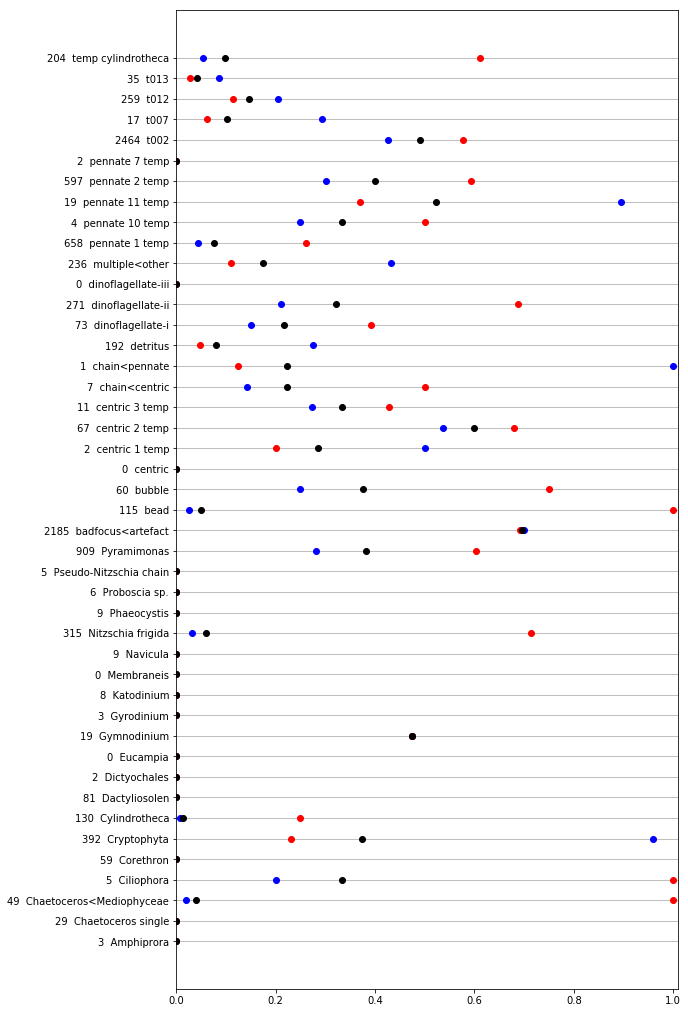

In [57]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

In [58]:
from sklearn.metrics import confusion_matrix
len(class_id_dict), confusion_matrix(np.array(all_labs), np.array(all_preds)).shape

(44, (41, 41))

In [60]:
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43])

In [65]:
all_labs.append(13)
all_labs.append(23)
all_labs.append(32)

In [66]:
all_preds.append(13)
all_preds.append(23)
all_preds.append(32)

Text(0.5, 312.22499999999985, 'Predicted label')

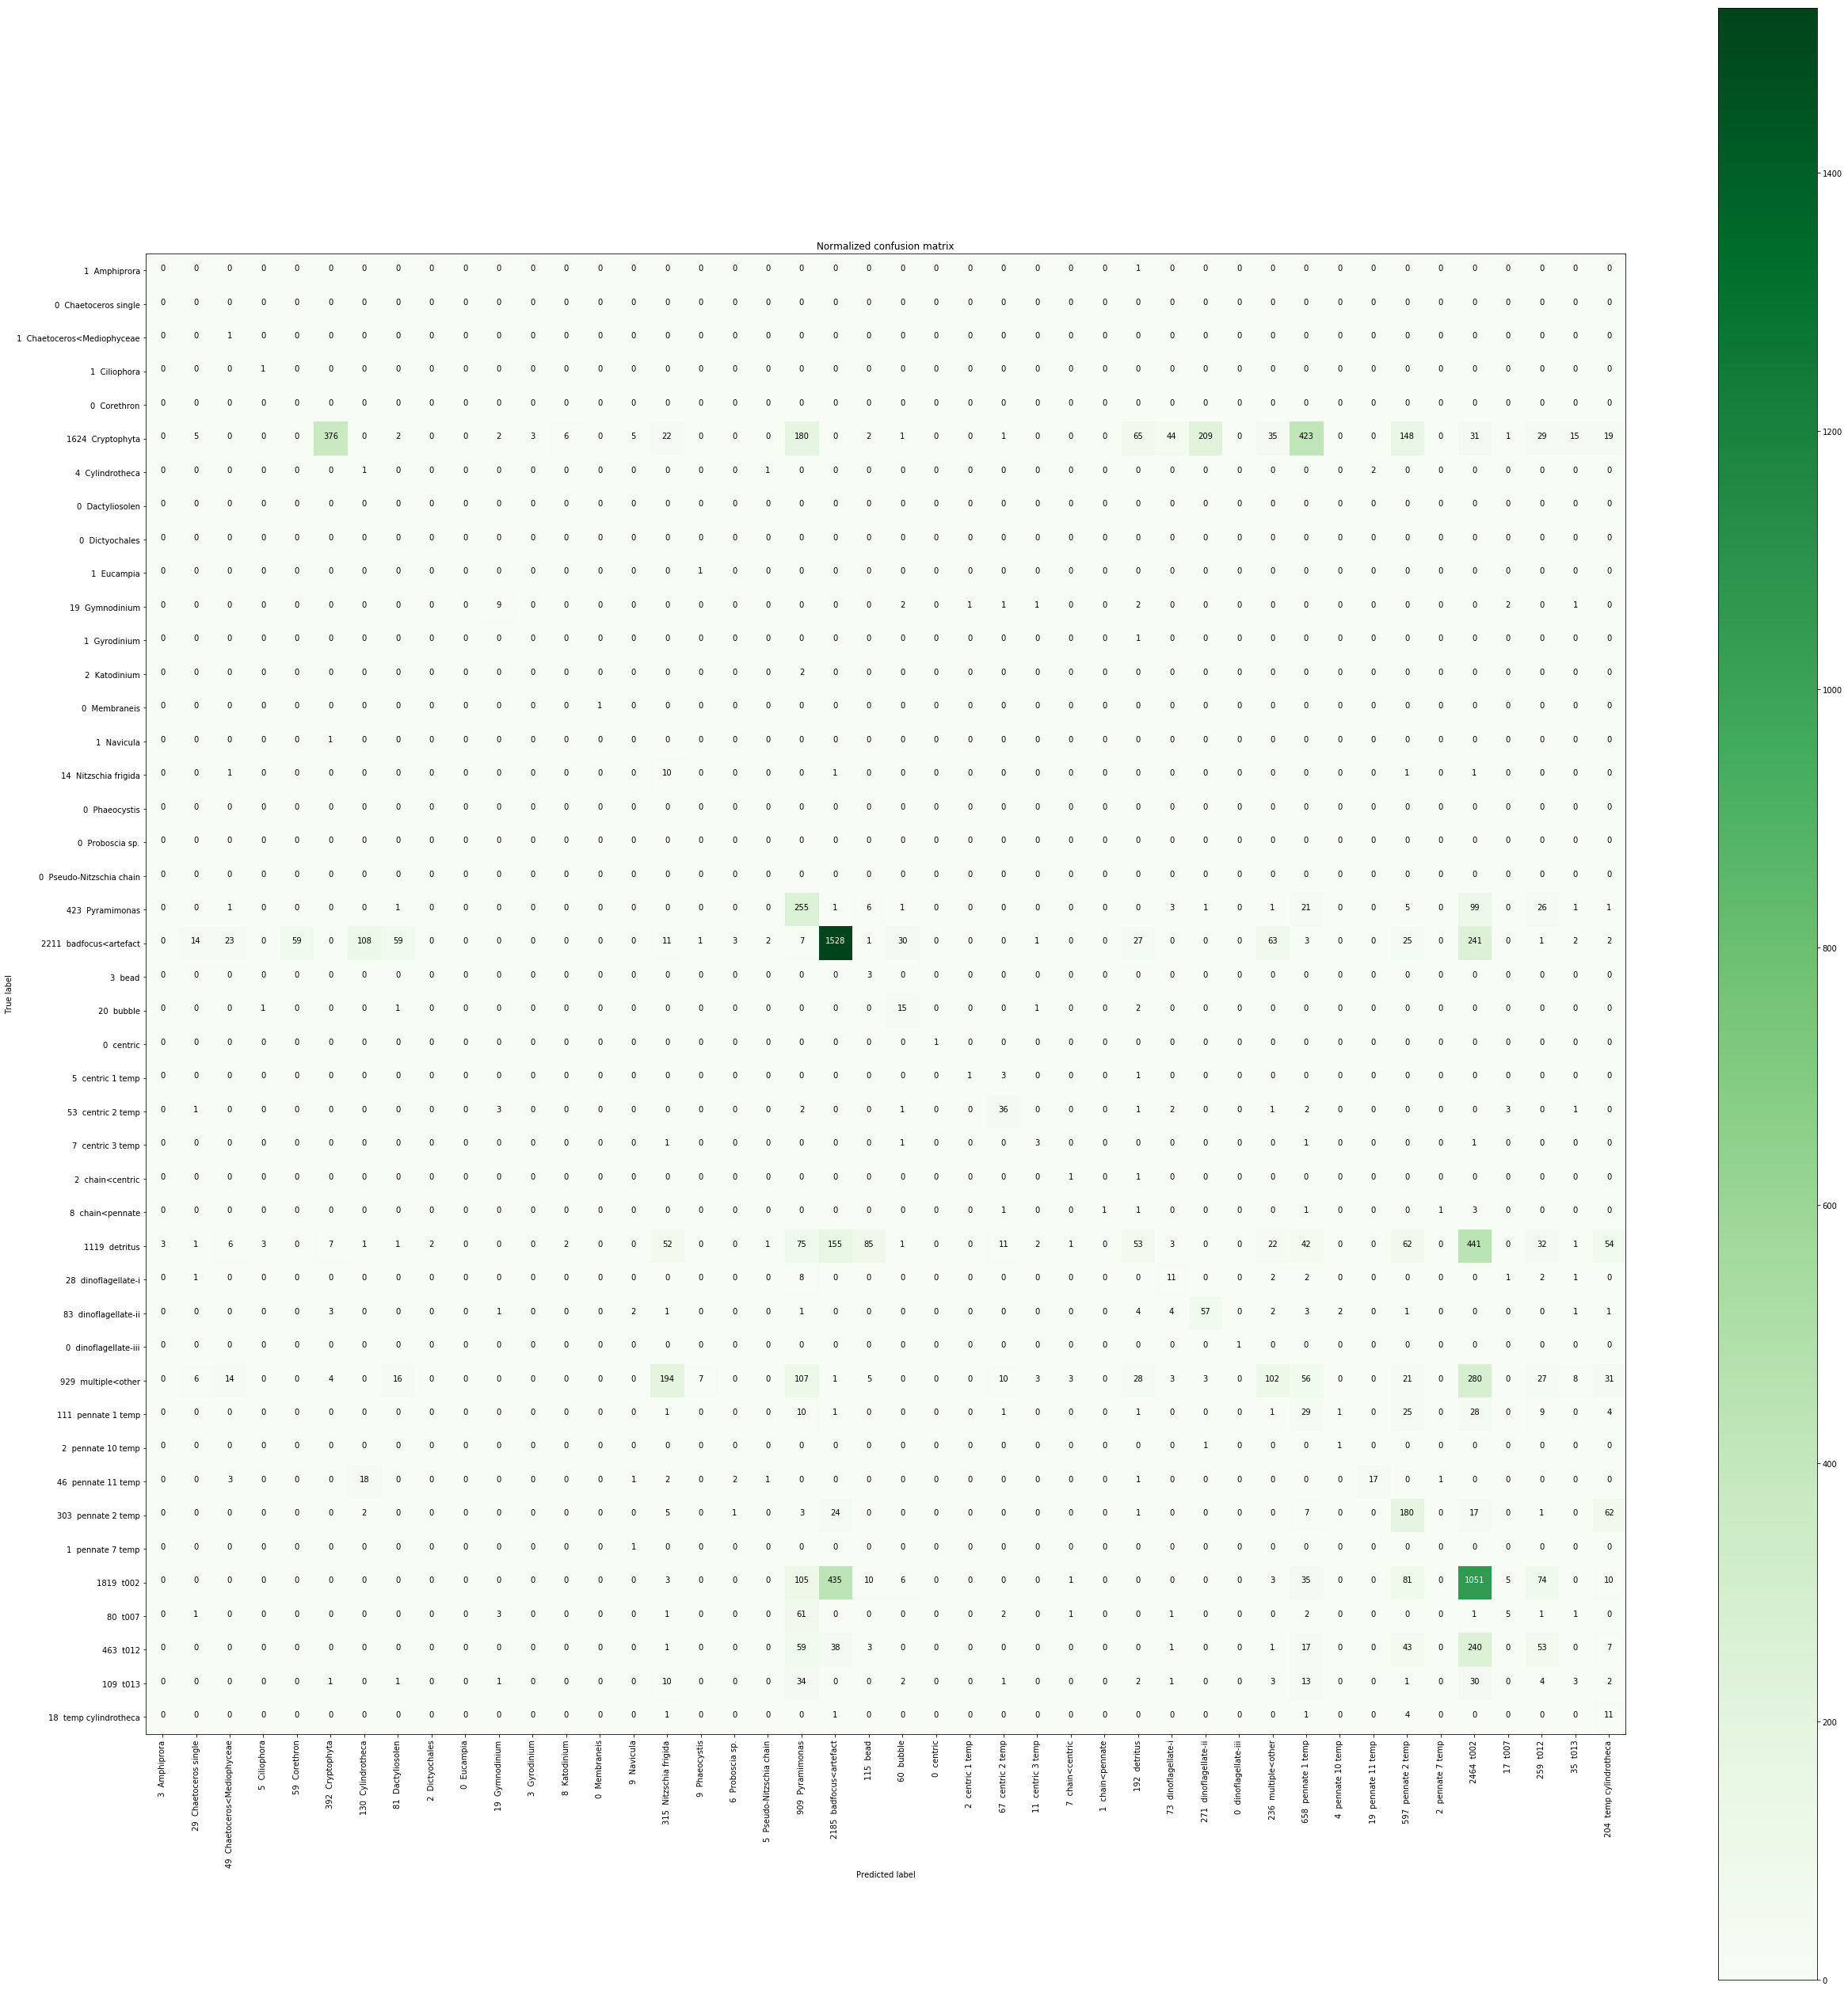

In [71]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(all_labs), np.array(all_preds))
#cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

#print(cm)
plt.figure(figsize=(35,35)) 

plt.imshow(cm, cmap = 'Greens')
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.0f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('../../conf_matrix_unmerged_visible_low_end_large_validated.png', dpi=300)

In [68]:
counts, classes

(array([   9,   12,   82,    6,   14,  559,   14,   23,    1,    2,   11,
           1,    1,  559,    3,    2,    2,  692, 2887,   84,  134,    1,
           7,   60,   45,   16,    3,  142,   54,  129,    1,  244,  365,
           3,   25,  571,    1, 1303,   33,  860,   42,  509]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43]))

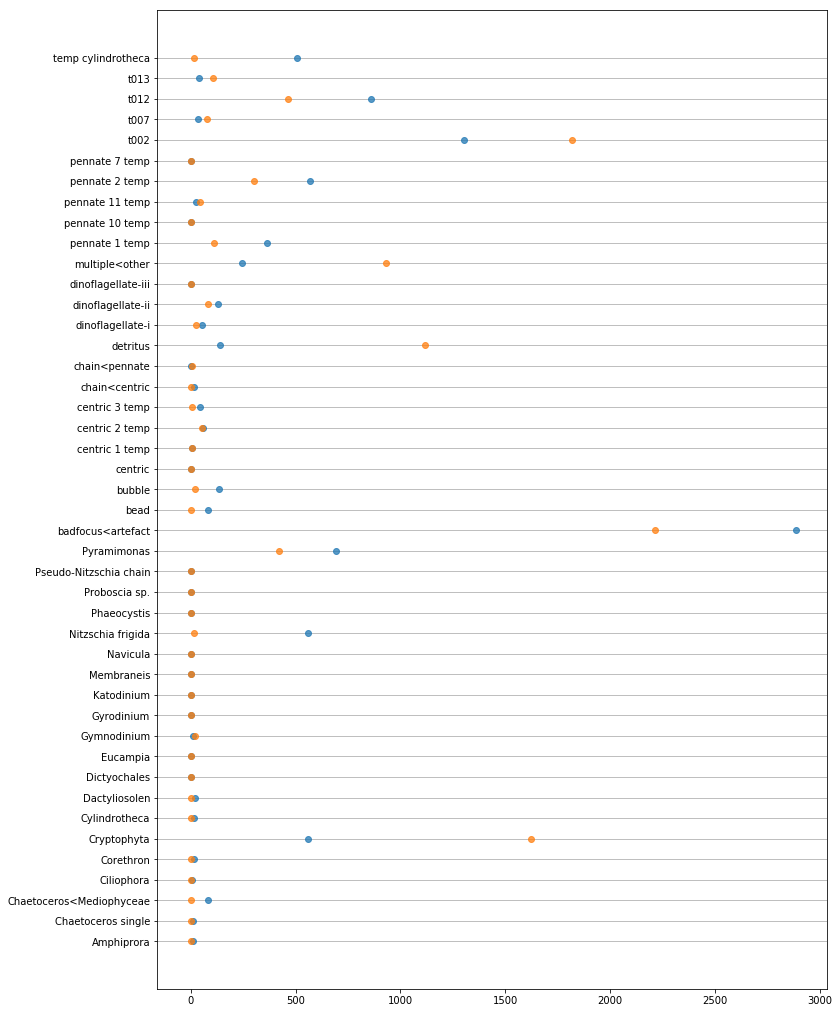

In [69]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(0,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Medium merged categories

In [72]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'badfocus<artefact': 20,
 'bead': 21,
 'bubble': 22,
 'centric': 23,
 'centric 1 temp': 24,
 'centric 2 temp': 25,
 'centric 3 temp': 26,
 'chain<centric': 27,
 'chain<pennate': 28,
 'detritus': 29,
 'dinoflagellate-i': 30,
 'dinoflagellate-ii': 31,
 'dinoflagellate-iii': 32,
 'multiple<other': 33,
 'pennate 1 temp': 34,
 'pennate 10 temp': 35,
 'pennate 11 temp': 36,
 'pennate 2 temp': 37,
 'pennate 7 temp': 38,
 't002': 39,
 't007': 40,
 't012': 41,
 't013': 42,
 'temp cylindrotheca': 43}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())
list(id_class_dict)

[id_class_dict[i] for i in range(len(id_class_dict))]

['Amphiprora',
 'Chaetoceros single',
 'Chaetoceros<Mediophyceae',
 'Ciliophora',
 'Corethron',
 'Cryptophyta',
 'Cylindrotheca',
 'Dactyliosolen',
 'Dictyochales',
 'Eucampia',
 'Gymnodinium',
 'Gyrodinium',
 'Katodinium',
 'Membraneis',
 'Navicula',
 'Nitzschia frigida',
 'Phaeocystis',
 'Proboscia sp.',
 'Pseudo-Nitzschia chain',
 'Pyramimonas',
 'badfocus<artefact',
 'bead',
 'bubble',
 'centric',
 'centric 1 temp',
 'centric 2 temp',
 'centric 3 temp',
 'chain<centric',
 'chain<pennate',
 'detritus',
 'dinoflagellate-i',
 'dinoflagellate-ii',
 'dinoflagellate-iii',
 'multiple<other',
 'pennate 1 temp',
 'pennate 10 temp',
 'pennate 11 temp',
 'pennate 2 temp',
 'pennate 7 temp',
 't002',
 't007',
 't012',
 't013',
 'temp cylindrotheca']

In [73]:
# Diatoms: 

## Pennate Diatoms:
amphiprora = ['Amphiprora']                    
banquisia_belgicae = ['Banquisia belgicae']
cylindrotheca = ['Cylindrotheca']                 
licmophora = ['Licmophora']
nitzschia_frigida = ['Nitzschia frigida']             
pseudo_nitzschia_chain = ['Pseudo-Nitzschia chain'] 

unidentified_single_pennate = [
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
    'pennate<Bacillariophyta'
]

## Centric Diatoms
chaetoceros_mediophyceae = ['Chaetoceros<Mediophyceae']
chaetoceros_single = ['Chaetoceros single']
corethron = ['Corethron']
eucampia_chain = ['Eucampia chain']
eucampia = ['Eucampia']
dactyliosolen = ['Dactyliosolen']
odontella = ['Odontella sp.']
proboscia = ['Proboscia sp.']
rhizosolenia = ['Rhizosolenia']
unidentified_single_centric = [
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric 4 temp',
    'centric 6 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

# Dinoflagellates: 
gyrodinium = ['Gyrodinium']
gymnodinium = ['Gymnodinium'] 
katodinium = ['Katodinium']
warnowia = ['Warnowia']
dinoflagellate_i = ['dinoflagellate-i']
dinoflagellate_ii = ['dinoflagellate-ii']
dinoflagellate_iii = ['dinoflagellate-iii']

dinophyceae = ['Dinophyceae']

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']
tintinnida = ['Tintinnida']

unidentified_flagellates = [ 
    't002',
    't005',
    't007',
    't009',
    't012',
    't013',
    't020'
]

unidentified_living_cells = [ 
    't006',
    't019'
]

other = [ 
    'bead',
    'bubble',
    'detritus',
    'badfocus<artefact',
    'multiple<other',
    #'Unknowns'
]

In [74]:
all_classes_sep = amphiprora+banquisia_belgicae+cylindrotheca+licmophora+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia_chain+eucampia+dactyliosolen+odontella +proboscia+rhizosolenia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+warnowia+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+dinophyceae+pyramimonas +phaeocystis+dictyochales +ciliophora +tintinnida+unidentified_flagellates+unidentified_living_cells+other
len(all_classes_sep)

60

In [75]:
class_str = 'amphiprora+banquisia_belgicae+cylindrotheca+licmophora+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia_chain+eucampia+dactyliosolen+odontella +proboscia+rhizosolenia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+warnowia+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+dinophyceae+pyramimonas +phaeocystis+dictyochales +ciliophora +tintinnida+unidentified_flagellates+unidentified_living_cells+other'
class_str.replace('+', ',')

'amphiprora,banquisia_belgicae,cylindrotheca,licmophora,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia_chain,eucampia,dactyliosolen,odontella ,proboscia,rhizosolenia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,warnowia,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,dinophyceae,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,tintinnida,unidentified_flagellates,unidentified_living_cells,other'

In [76]:
class_str.replace('+', "','")

"amphiprora','banquisia_belgicae','cylindrotheca','licmophora','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia_chain','eucampia','dactyliosolen','odontella ','proboscia','rhizosolenia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','warnowia','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','dinophyceae','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','tintinnida','unidentified_flagellates','unidentified_living_cells','other"

### adding all the merged classes into the dataframe

In [77]:
classes = [amphiprora,banquisia_belgicae,cylindrotheca,licmophora,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia_chain,eucampia,dactyliosolen,odontella ,proboscia,rhizosolenia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,warnowia,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,dinophyceae,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,tintinnida,unidentified_flagellates,unidentified_living_cells,other]

class_names = ['amphiprora','banquisia_belgicae','cylindrotheca','licmophora','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia_chain','eucampia','dactyliosolen','odontella ','proboscia','rhizosolenia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','warnowia','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','dinophyceae','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','tintinnida','unidentified_flagellates','unidentified_living_cells','other']

live_preds["merged_category"] = ""
for i in range(len(classes)):
    live_preds['merged_category'][live_preds['object_annotation_category'].isin(classes[i])] = class_names[i]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [78]:
classes = [amphiprora,banquisia_belgicae,cylindrotheca,licmophora,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia_chain,eucampia,dactyliosolen,odontella ,proboscia,rhizosolenia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,warnowia,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,dinophyceae,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,tintinnida,unidentified_flagellates,unidentified_living_cells,other]

class_names = ['amphiprora','banquisia_belgicae','cylindrotheca','licmophora','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia_chain','eucampia','dactyliosolen','odontella ','proboscia','rhizosolenia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','warnowia','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','dinophyceae','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','tintinnida','unidentified_flagellates','unidentified_living_cells','other']

live_preds["val_merged_category"] = ""
for i in range(len(classes)):
    live_preds['val_merged_category'][live_preds['validated_type'].isin(classes[i])] = class_names[i]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [79]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [80]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])

In [81]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'amphiprora',
 1: 'banquisia_belgicae',
 2: 'cylindrotheca',
 3: 'licmophora',
 4: 'nitzschia_frigida',
 5: 'pseudo_nitzschia_chain',
 6: 'unidentified_single_pennate',
 7: 'chaetoceros_mediophyceae',
 8: 'chaetoceros_single',
 9: 'corethron',
 10: 'eucampia_chain',
 11: 'eucampia',
 12: 'dactyliosolen',
 13: 'odontella ',
 14: 'proboscia',
 15: 'rhizosolenia ',
 16: 'unidentified_single_centric',
 17: 'cryptophyta',
 18: 'gyrodinium',
 19: 'gymnodinium',
 20: 'katodinium',
 21: 'warnowia',
 22: 'dinoflagellate_i',
 23: 'dinoflagellate_ii ',
 24: 'dinoflagellate_iii',
 25: 'dinophyceae',
 26: 'pyramimonas ',
 27: 'phaeocystis',
 28: 'dictyochales ',
 29: 'ciliophora ',
 30: 'tintinnida',
 31: 'unidentified_flagellates',
 32: 'unidentified_living_cells',
 33: 'other'}

In [82]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

(9515, 9515)

In [83]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

(9515, 9515)

In [84]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

(0.6750290541183043, 0.49448239621650025, 0.5229403985716542, None)

In [85]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [86]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

In [87]:
len(class_id_dict), confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id)).shape

(34, (25, 25))

In [88]:
classes, counts = np.unique(merged_labs_id, return_counts=True)
true_classes, true_counts = np.unique(merged_truth_id, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

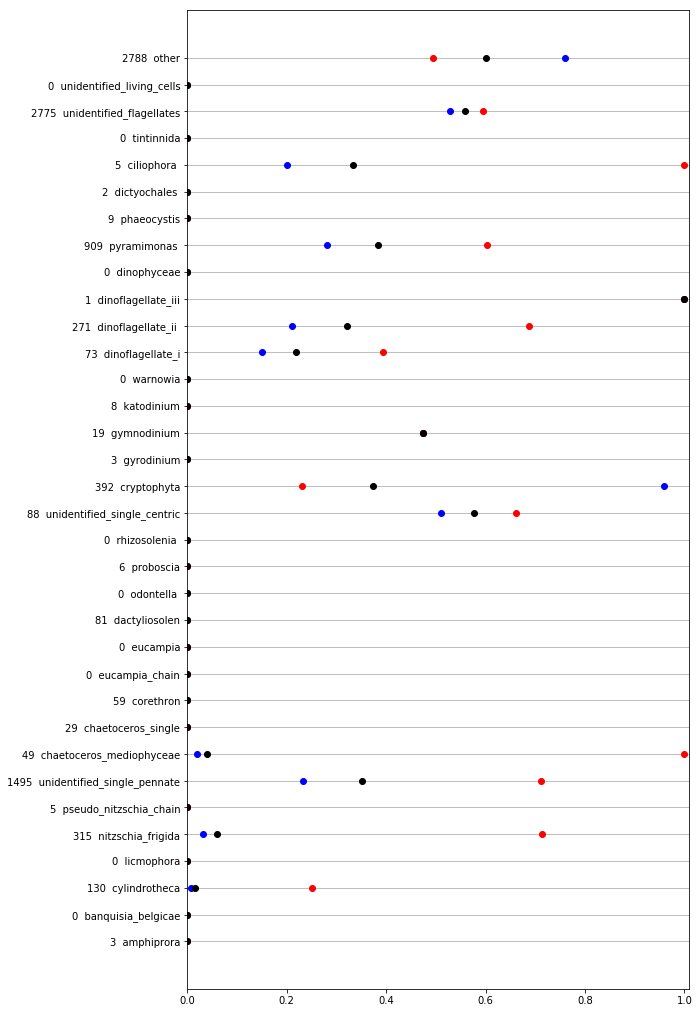

In [89]:
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0.5, 23.89999999999995, 'Predicted label')

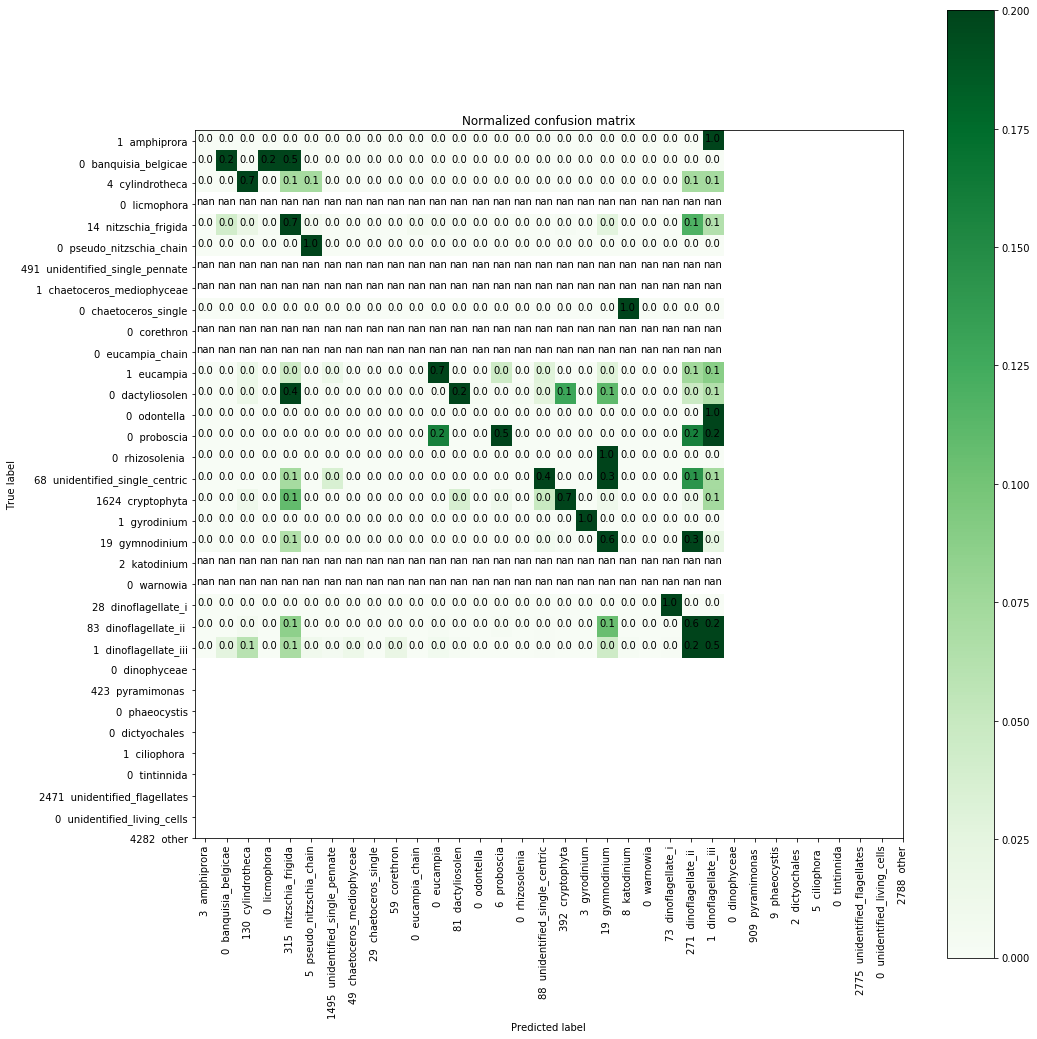

In [90]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_truth_id), np.array(merged_labs_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_medium_merged.png', dpi=300)

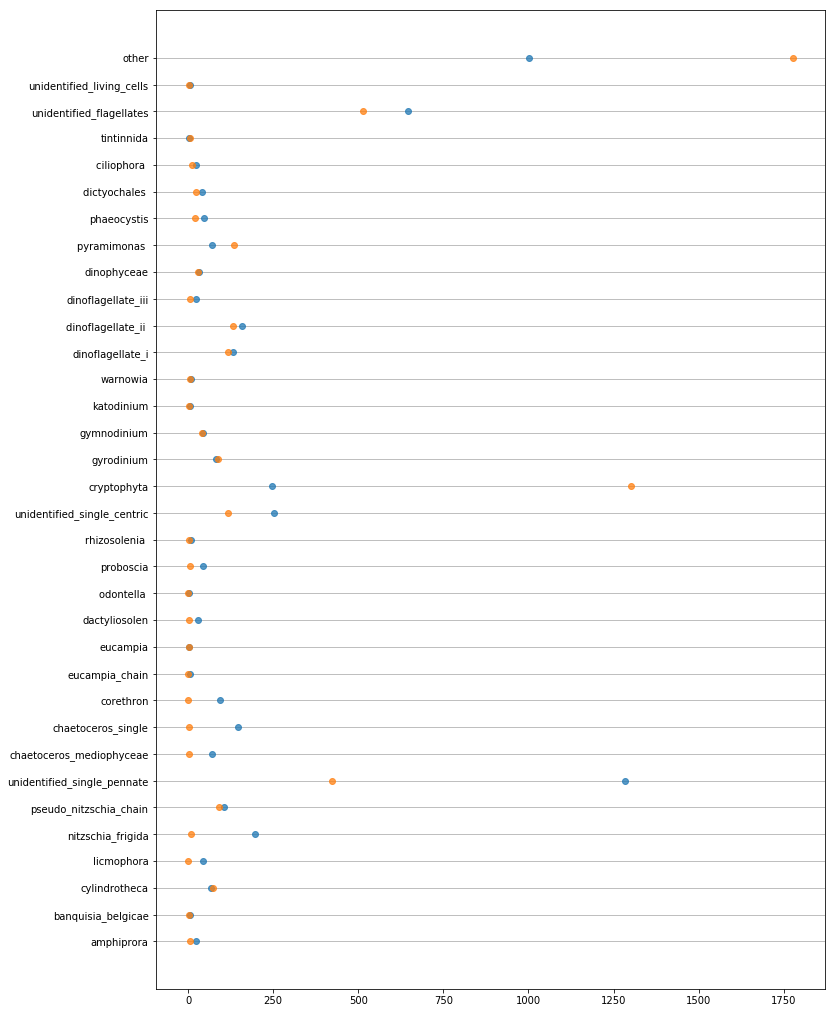

In [78]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Now moving to super merged categories

In [ ]:
class_id_dict = {'Amphiprora': 0,
 'Banquisia belgicae': 1,
 'Chaetoceros single': 2,
 'Chaetoceros<Mediophyceae': 3,
 'Ciliophora': 4,
 'Corethron': 5,
 'Cryptophyta': 6,
 'Cylindrotheca': 7,
 'Dactyliosolen': 8,
 'Dictyochales': 9,
 'Dinophyceae': 10,
 'Eucampia': 11,
 'Eucampia chain': 12,
 'Gymnodinium': 13,
 'Gyrodinium': 14,
 'Katodinium': 15,
 'Licmophora': 16,
 'Membraneis': 17,
 'Navicula': 18,
 'Nitzschia frigida': 19,
 'Odontella sp.': 20,
 'Phaeocystis': 21,
 'Proboscia sp.': 22,
 'Pseudo-Nitzschia chain': 23,
 'Pyramimonas': 24,
 'Rhizosolenia': 25,
 'Tintinnida': 26,
 'Warnowia': 27,
 'badfocus<artefact': 28,
 'bead': 29,
 'bubble': 30,
 'centric': 31,
 'centric 1 temp': 32,
 'centric 2 temp': 33,
 'centric 3 temp': 34,
 'centric 4 temp': 35,
 'centric 6 temp': 36,
 'chain<centric': 37,
 'chain<pennate': 38,
 'detritus': 39,
 'dinoflagellate-i': 40,
 'dinoflagellate-ii': 41,
 'dinoflagellate-iii': 42,
 'multiple<other': 43,
 'pennate 1 temp': 44,
 'pennate 10 temp': 45,
 'pennate 11 temp': 46,
 'pennate 2 temp': 47,
 'pennate 7 temp': 48,
 'pennate<Bacillariophyta': 49,
 't002': 50,
 't005': 51,
 't006': 52,
 't007': 53,
 't009': 54,
 't012': 55,
 't013': 56,
 't019': 57,
 't020': 58,
 'temp cylindrotheca': 59}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())
list(id_class_dict)

[id_class_dict[i] for i in range(len(id_class_dict))]

In [ ]:
# Diatoms: 

## Pennate Diatoms:
pennates = [
    'Amphiprora',                    
    'Banquisia belgicae',
    'Cylindrotheca'  ,             
    'Licmophora',
    'Nitzschia frigida'  ,        
    'Pseudo-Nitzschia chain',
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
    'pennate<Bacillariophyta'
]

## Centric Diatoms
centrics = [
    'Chaetoceros<Mediophyceae',
    'Chaetoceros single',
    'Corethron',
    'Eucampia chain',
    'Eucampia',
    'Dactyliosolen',
    'Odontella sp.',
    'Proboscia sp.',
    'Rhizosolenia',
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric 4 temp',
    'centric 6 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

dinoflagellates = [
    'Gyrodinium',
    'Gymnodinium',
    'Katodinium',
    'Warnowia',
    'dinoflagellate-i',
    'dinoflagellate-ii',
    'dinoflagellate-iii',
    'Dinophyceae'
]

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']
tintinnida = ['Tintinnida']

unidentified_flagellates = [ 
    't002',
    't005',
    't007',
    't009',
    't012',
    't013',
    't020'
]

unidentified_living_cells = [ 
    't006',
    't019'
]

other = [ 
    'bead',
    'bubble',
    'detritus',
    'badfocus<artefact',
    'multiple<other'
]

In [ ]:
all_classes = list(live_preds.groupby('object_annotation_category')['object_id'].nunique().index)

In [ ]:
all_classes_sep = pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+tintinnida+unidentified_flagellates+unidentified_living_cells+other
len(all_classes), len(all_classes_sep)

In [ ]:
list(set(all_classes) - set(all_classes_sep))

In [ ]:
list(set(all_classes_sep) - set(all_classes))

In [ ]:
class_str = 'pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+tintinnida+unidentified_flagellates+unidentified_living_cells+other'
class_str.replace('+', ',')

In [ ]:
class_str.replace('+', "','")

### adding all the merged classes into the dataframe

In [ ]:
classes = [pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,tintinnida,unidentified_flagellates,unidentified_living_cells,other]

class_names = ['pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','tintinnida','unidentified_flagellates','unidentified_living_cells','other']

live_preds["merged_category"] = ""
for i in range(len(classes)):
    live_preds['merged_category'][live_preds['object_annotation_category'].isin(classes[i])] = class_names[i]

In [ ]:
classes = [pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,tintinnida,unidentified_flagellates,unidentified_living_cells,other]

class_names = ['pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','tintinnida','unidentified_flagellates','unidentified_living_cells','other']

live_preds["val_merged_category"] = ""
for i in range(len(classes)):
    live_preds['val_merged_category'][live_preds['validated_type'].isin(classes[i])] = class_names[i]

In [ ]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [ ]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])

In [ ]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

In [ ]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

In [ ]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [ ]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

In [ ]:
len(class_id_dict), confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id)).shape

In [ ]:
classes, counts = np.unique(merged_labs_id, return_counts=True)
true_classes, true_counts = np.unique(merged_truth_id, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

In [ ]:
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_truth_id), np.array(merged_labs_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_medium_merged.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()